In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 15)

from sklearn import linear_model, metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [12]:
#df = pd.read_csv(os.path.join('..', 'datasets', 'C:/Users/tcaballero/DS-SF-30/final-project/tiny cube binary.csv'))
df = pd.read_csv(os.path.join('..', 'datasets', 'C:/Users/tcaballero/DS-SF-30/final-project/Customer Cube - 1.30.17.csv'))
#df = pd.read_csv(os.path.join('..', 'datasets', 'C:/Users\tcaballero/Dropbox (Optimizely)/Finance/FP&A/Shared Folders/Tony/cube file/python/Customer Cube - 1.30.17.csv'))
df

,customer_code,for_month,mrr,last_yr,last_mrr,...,billing_period,age,contract_start_date,retention,churn_dollars
0,A1,7/1/2016,1000,NaN,NaN,...,Quarter,38.0,3/9/2016,NaN,NaN
1,A1,8/1/2016,0,NaN,NaN,...,Quarter,38.0,3/9/2016,NaN,NaN
2,A1,9/1/2016,1000,NaN,NaN,...,Quarter,38.0,3/9/2016,NaN,NaN
3,A1,10/1/2016,1000,NaN,NaN,...,Quarter,38.0,3/9/2016,NaN,NaN
4,A1,11/1/2016,1000,NaN,NaN,...,Quarter,38.0,3/9/2016,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
62517,A2312,8/1/2016,0,8/1/2015,0.0,...,NaN,NaN,NaN,NaN,NaN
62518,A2312,9/1/2016,0,9/1/2015,0.0,...,NaN,NaN,NaN,NaN,NaN
62519,A2312,10/1/2016,0,10/1/2015,0.0,...,NaN,NaN,NaN,NaN,NaN
62520,A2312,11/1/2016,0,11/1/2015,0.0,...,NaN,NaN,NaN,NaN,NaN


In [13]:
rows = df.shape[0]
cols = df.shape[1]
print "rows = {} and columns = {}".format(rows, cols)
print df.dtypes

rows = 62522 and columns = 39
customer_code           object
for_month               object
mrr                      int64
last_yr                 object
last_mrr               float64
                        ...   
billing_period          object
age                    float64
contract_start_date     object
retention              float64
churn_dollars          float64
dtype: object


In [14]:
df[[5,6,7,8,9,10,11,12,13,14]].isnull().sum()

mobile_experiments_started    0
experiments_started           0
allocation                    0
utilization                   0
tickets_created               0
impressions                   0
impression_revenue            0
knowledge_base_views          0
logins                        0
sig_exp_90                    0
dtype: int64

In [46]:
#df_sigexp0 = df[['sig_exp_90'==1,'logins']]
df_sigexp = pd.get_dummies(df.sig_exp_90, prefix = 'sig_exp')
#df_sigexp.shape

0         True
1         True
2         True
3         True
4         True
         ...  
62517    False
62518    False
62519    False
62520    False
62521    False
Name: new_feature, dtype: bool

In [48]:
#compare distribution of values for when sig_exp = 0 vs 1
df.sig_exp_90.value_counts(dropna = False).sort_index()

0    48392
1    14130
Name: sig_exp_90, dtype: int64

In [72]:
df['sig_exp_check'] = (df.sig_exp_90 == 1)
df.columns
#created a new feature and added this column to the original dataframe

Index([u'customer_code', u'for_month', u'mrr', u'last_yr', u'last_mrr',
       u'mobile_experiments_started', u'experiments_started', u'allocation',
       u'utilization', u'tickets_created', u'impressions',
       u'impression_revenue', u'knowledge_base_views', u'logins',
       u'sig_exp_90', u'brand_ops', u'running_experiment_days', u'vertical',
       u'segment', u'country', u'region', u'number_of_employees', u'traffic',
       u'annual_revenue', u'account_potential_score', u'ae', u'csm',
       u'partner_flag', u'first_month', u'last_month', u'last record',
       u'churned', u'days_overdue', u'collaborators_added', u'billing_period',
       u'age', u'contract_start_date', u'retention', u'churn_dollars',
       u'sig_exp_check'],
      dtype='object')

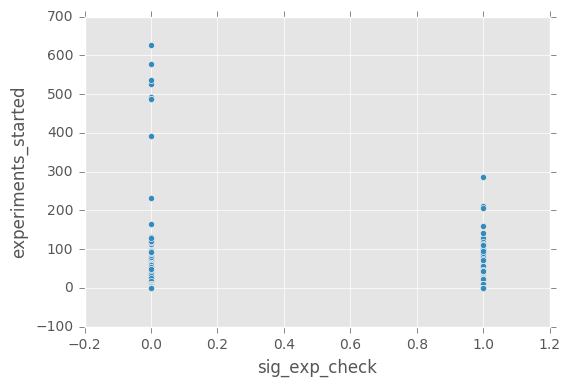

In [67]:
df.plot(kind = 'scatter', x = 'sig_exp_check', y = 'experiments_started')
#appears to be some colinearity between these 2 independent variables. I'm looking to explain retention as the ultimate y variable
#sig_exp_check = 0 has twice the range that =1 has. 

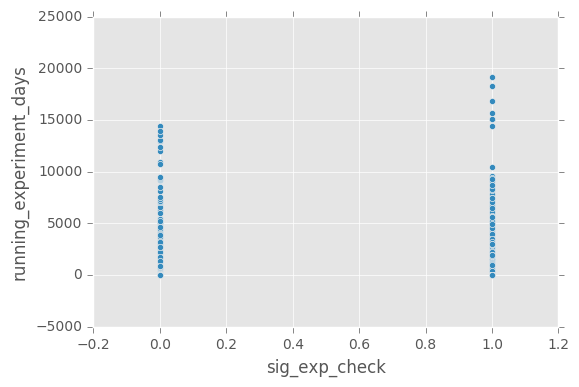

In [68]:
df.plot(kind = 'scatter', x = 'sig_exp_check', y = 'running_experiment_days')

In [10]:
model = smf.ols(formula = 'churn_dollars ~ logins + running_experiment_days + utilization', data = df).fit()

model.summary()
#only utilization and intercept seem to be significant 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          churn_dollars   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     197.0
Date:                Sun, 12 Feb 2017   Prob (F-statistic):          1.44e-126
Time:                        16:00:12   Log-Likelihood:            -2.7455e+05
No. Observations:               31003   AIC:                         5.491e+05
Df Residuals:                   30999   BIC:                         5.491e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                -832.6603     10.849    -76.752      0.000      -853.924  -811.396
logins                      0.2140      0.024      8.794      0.000         0.166     0.262
running_experiment_days     0.1970      0.015     13.410      0.000         0.168     0.226
utilization              2.938e-05   4.59e-06      6.399      0.000      2.04e-05  3.84e-05
==============================================================================
Omnibus:                    33286.500   Durbin-Watson:                   0.670
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5085777.033
Skew:                          -5.201   Prob(JB):                         0.00
Kurtosis:                      64.877   Cond. No.                     2.60e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

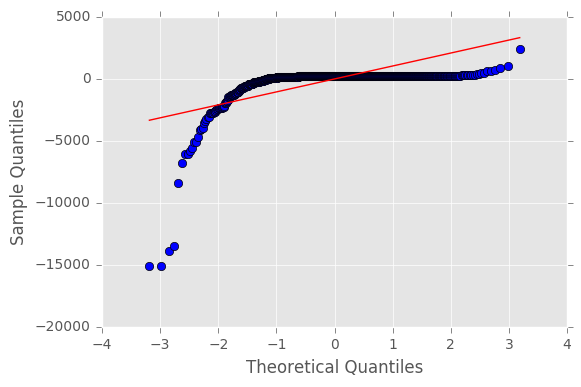

In [8]:
sm.qqplot(model.resid, line = 's')

pass
#VERY NOT NORMALLY DISTRIBUTED. Probably shouldn't continue with regression. 

In [10]:
#shift gocus to try logistic regression and use churn binary flag as 

In [70]:
train_df = df.sample(frac = .75, random_state = 0)
test_df = df.drop(train_df.index)

In [23]:
train_df.columns

Index([u'customer_id', u'for_month', u'mrr', u'last_yr', u'last_mrr',
       u'sig_exp_90', u'partner_flag', u'logins', u'running_experiment_days',
       u'utilization', u'churn_dollars', u'churned'],
      dtype='object')

In [11]:
names_X = ['sig_exp_90', 'partner_flag', 'logins',
    'running_experiment_days', 'utilization']       #, 'churn_dollars']

def X_c(df):
    X = df[ names_X ]
    c = df.churned
    return X, c

train_X, train_c = X_c(train_df)
test_X, test_c = X_c(test_df)

SyntaxError: invalid syntax (<ipython-input-11-9dc7f2259f50>, line 1)

In [ ]:
model = linear_model.LogisticRegression().fit(train_X, train_c)

print model.intercept_
print model.coef_

In [34]:
model = linear_model.LogisticRegression().\
    fit(test_X, test_c)

print model.intercept_
print model.coef_

[ 0.00068708]
[[  5.95686049e-04   1.72235218e-04   3.14446083e-02  -1.35420224e-02
   -3.09179648e-07]]


In [35]:
print 'training misclassification =', 1 - model.score(train_X, train_c)
print 'testing  misclassification =', 1 - model.score(test_X, test_c)

training misclassification = 0.166185804962
testing  misclassification = 0.160899653979
